<a href="https://colab.research.google.com/github/ek-ok/DeepShack/blob/poc/train/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

import os
os.chdir('/content/drive/My Drive/Colab Notebooks/DeepShack/train')

In [1]:
%load_ext autoreload
%autoreload 2

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from model import MultiScaleCNN, FullyConnected
from image_handlers import ImageLoader, ShackCamLoader

SyntaxError: invalid syntax (model.py, line 28)

In [ ]:
image_dir = 'a'
name = 'b'

to_file=f"{image_dir}/results/{name}.png"

#  Multi-Scale CNN model training strategy 

1. Train a model with mall data
2. Further train the model with ShackCam data
3. Adding FC layers and training only the FC layers by setting `mscnn_layer.trainable = False`

# 1. Train a model with mall data

### Load mall data

In [2]:
new_shape = 160

In [ ]:
mall = ImageLoader(new_shape=new_shape, image_dir='data/mall')
mall.load_train_data()
mall.plot_image(filename='seq_000499.jpg')
print('Total image samples', len(mall.count))

### Create a model

In [ ]:
input_shape = (new_shape, new_shape, 3)

In [ ]:
model = MultiScaleCNN(input_shape=input_shape, name='mall')

###  Split data to train/test

In [ ]:
train_size = 0.8

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(mall.org_img, mall.gaussian_img, train_size=train_size)
print('x_train', x_train.shape, 'x_test', x_test.shape)
print('y_train', y_train.shape, 'y_test', y_test.shape)

### Assign optimizer and compile a model

In [ ]:
model.train(x_train, y_train, epochs=30, batch_size=32)

In [ ]:
model.evaluate(x_test, y_test)

# 2. Further train the same model with ShackCam data

### Load shackcam data

Total image samples 3878


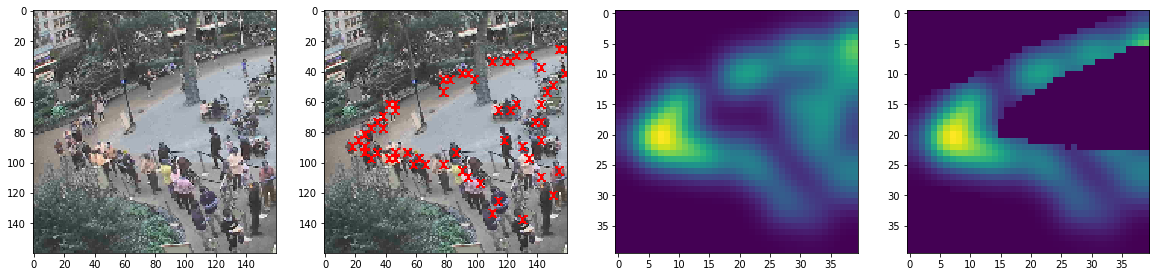

In [3]:
shackcam = ShackCamLoader(new_shape=new_shape, image_dir='data/shackcam')
shackcam.load_train_data()
shackcam.plot_image(i=500)
print('Total image samples', len(shackcam.count))

### Split data to train/test

In [6]:
shackcam.data[:1]

TypeError: unhashable type: 'slice'

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(shackcam.org_img, shackcam.gaussian_img, 
                                                    train_size=train_size)
print('x_train', x_train.shape, 'x_test', x_test.shape)
print('y_train', y_train.shape, 'y_test', y_test.shape)

### Load pre-trained weights

In [ ]:
model = MultiScaleCNN(input_shape=input_shape, name='shackcam', 
                      existing_model_path='results/shackcam.h5')

### Assign optimizer and compile a model

In [ ]:
model.train(x_train, y_train, lr=0.0005, epochs=5, batch_size=32)

In [ ]:
model.model.predict(x_test[0:1]).sum()
# x_test[0:1].shape

### Save results and inspect loss

In [ ]:
model.evaluate(x_test, y_test)

# Adding FC layers and training only the FC layers

### Read line counts, align order as shackcam annotations, remove files without counts

In [ ]:
counts = pd.read_csv('data/shackcam/line_counts.csv', names=['file', 'line_count'], header=None)
counts = counts[counts.file.isin(shackcam.files)].reset_index(drop=True)
masked_gaussian_img = np.array([shackcam.mask_img(shackcam.data[f]['gaussian_img']) for f in counts.file])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(masked_gaussian_img, counts.line_count.values, 
                                                    train_size=train_size)
print('x_train', x_train.shape, 'x_test', x_test.shape)
print('y_train', y_train.shape, 'y_test', y_test.shape)

In [ ]:
input_shape = (new_shape//4, new_shape//4, 1)
model = FullyConnected(input_shape=input_shape, name='shackcam_fc')

In [ ]:
model.train(x_train, y_train, lr=0.001, epochs=200, batch_size=512)

In [ ]:
model.evaluate(x_test, y_test)

### Predict

In [ ]:
def predict(i):
  shackcam.plot_image(i=i)
  pred = model.model.predict(shackcam.gaussian_img[i].reshape((1, *input_shape)))[0][0]
  truth = counts.iloc[i, 1]
  print('Pred', int(round(pred)))
  print('Truth', truth)

In [ ]:
predict(1630)

In [ ]:
predict(100)

In [ ]:
predict(1084)

# Predict density

In [ ]:
from tensorflow.python.keras.models import load_model
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
mscnn = load_model('results/mall.h5')
fc = load_model('results/shackcam_fc.h5')

In [ ]:
mscnn.predict(np.expand_dims(shackcam.org_img[1], axis=0)).sum()